# Задание к занятию «Обзор библиотеки XGBoost»

In [ ]:
Описание задания:

Что делать

    - Решите уже знакомую задачу регрессии — предсказание цены на недвижимость. Датасет — train.csv;
    - Используйте objective = "reg:linear" в xgboost;
    - Настройте гиперпараметры, используя hyperopt либо ручную настройку (как вам больше нравится);
    - Используйте отложенную выборку (как на занятии), чтобы следить за процессом обучения xgboost'а, но — как и в предыдущем домашнем задании — финальную оценку качества давайте, используя 10-fold кросс-валидацию;
    - Проанализируйте, насколько согласованы оценка на отложенной выборке и на кросс-валидации (одновременно уменьшаются/увеличиваются при изменении гиперпараметров или ведут себя по-разному);
    - Проанализируйте признаки, используя XGBFI, сделайте выводы об интересных взаимодействиях;


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

### Подготовка данных

In [2]:
X_full = pd.read_csv('train.csv.gz', compression='gzip', index_col='Id')
X_val = pd.read_csv('test.csv.gz', compression='gzip', index_col='Id')

In [3]:
X_full.shape, X_val.shape

((1460, 80), (1459, 79))

In [4]:
X_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
X_full.MSSubClass = X_full.MSSubClass.astype('str')
X_val.MSSubClass = X_val.MSSubClass.astype('str')
X_full.SalePrice = X_full.SalePrice.astype('float64')
y_full = X_full.SalePrice
X_full.drop('SalePrice', axis=1, inplace=True)

In [6]:
cat_feat = X_full.dtypes[X_full.dtypes == "object"].index.tolist()
num_feat = X_full.dtypes[X_full.dtypes != "object"].index.tolist()
set(X_full.columns) == set(cat_feat + num_feat)

True

In [7]:
X_full[cat_feat] = X_full[cat_feat].fillna('nan')
X_val[cat_feat] = X_val[cat_feat].fillna('nan')

In [ ]:
dummy_full = pd.get_dummies(X_full[cat_feat], columns=cat_feat)
dummy_val = pd.get_dummies(X_val[cat_feat], columns=cat_feat)

cat_feat = list(set(dummy_full) & set(dummy_val))

dummy_full = dummy_full[cat_feat]
dummy_val = dummy_val[cat_feat]
#X_full = pd.concat([X_full[num_feat], dummy_full], axis=1)
#X_val = pd.concat([X_val[num_feat], dummy_val], axis=1)
#Для деревянных моделей заполняем пустые значения числовых признаков константой -999
X_full = pd.concat([X_full[num_feat].fillna(-999), dummy_full], axis=1)
X_val = pd.concat([X_val[num_feat].fillna(-999), dummy_val], axis=1)

In [9]:
X_full.shape, X_val.shape, y_full.shape

((1460, 299), (1459, 299), (1460,))

In [10]:
X_full.isnull().sum().sort_values(ascending=False).head()

Neighborhood_Blueste    0
PavedDrive_Y            0
PavedDrive_N            0
CentralAir_Y            0
SaleType_New            0
dtype: int64

Т.к. xgboost не поддерживает метрику MSLE, то от целевой ф-ции берем логарифм log(1+y) и используем метрику RMSE. В конце предсказанные значения переведем обратно с помощью np.expm1(y) 

In [11]:
y_full = np.log1p(y_full)

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.20, random_state=555)

## Модели

Сначала сравниваем модели RandomForest, AdaBoosting, GradientBoosting и XGBOOST. Далее проводим дополнительный подбор параметров XGBOOST

### RandomForest

In [13]:
msle_scores = pd.Series()

In [14]:
def find_params(clf, param_grid, scoring='neg_mean_squared_error', n_iter=50, fit_params={}):
    clf_grid = RandomizedSearchCV(
        clf, 
        param_distributions=param_grid, 
        cv=10, 
        n_jobs=-1, 
        scoring=scoring, 
        random_state=42, 
        n_iter=n_iter, 
#        fit_params = fit_params
#        verbose=3
    )
    clf_grid.fit(X_train, y_train, **fit_params)
#    best_prep_params = clf_grid.best_estimator_.named_steps['prep'].get_params()
    best_params = clf_grid.best_estimator_.named_steps['reg'].get_params()
    best_score = -clf_grid.best_score_
    msle_scores[clf_grid.best_estimator_.named_steps['reg'].__class__.__name__] = -clf_grid.score(X_test, y_test)
    print(clf_grid.best_estimator_.named_steps['reg'].__class__.__name__)
#    print('Best prep params: {}'.format(best_prep_params))
    print('Best params: {}'.format(best_params))
    print('MSLE на cv: {}'.format(best_score))
    print('MSLE на train: {}'.format(-clf_grid.score(X_train, y_train)))
    print('MSLE на test: {}'.format(-clf_grid.score(X_test, y_test)))
    return clf_grid.best_estimator_.named_steps['reg'], best_params

In [15]:
rf_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', RandomForestRegressor(random_state=42))
])
rf_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'reg__bootstrap': [True, False],
    'reg__n_estimators': [50],
    'reg__max_features': uniform(loc=0.1, scale=0.9),
    'reg__max_depth': randint(low=1, high=20),
    'reg__min_samples_leaf': randint(low=5, high=20)
}
_, best_params = find_params(rf_pipe, rf_params, 'neg_mean_squared_error', 50)


RandomForestRegressor
Best params: {'bootstrap': False, 'criterion': 'mse', 'max_depth': 12, 'max_features': 0.3266040662428278, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 6, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
MSLE на cv: 0.02105907659396808
MSLE на train: 0.006618286295330821
MSLE на test: 0.0180845085181941


In [16]:
msle_scores

RandomForestRegressor    0.018085
dtype: float64

### AdaBoost

In [17]:
ada_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(),
        random_state=42
    ))
])
ada_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'reg__n_estimators': [50],
    'reg__learning_rate': uniform(loc=0.05, scale=0.5),
    'reg__base_estimator__max_features': uniform(loc=0.1, scale=0.9),
    'reg__base_estimator__max_depth': randint(low=1, high=10),
    'reg__base_estimator__min_samples_leaf': randint(low=5, high=20)
}
_, best_params = find_params(ada_pipe, ada_params, 'neg_mean_squared_error', 50)


AdaBoostRegressor
Best params: {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': 9, 'base_estimator__max_features': 0.5363469742230849, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=9,
           max_features=0.5363469742230849, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'), 'learning_rate': 0.1099326836668414, 'loss': 'linear', 'n_estimators': 50, 'random_state': 42}
MSLE на cv: 0.02154917474844446
M

In [18]:
msle_scores

RandomForestRegressor    0.018085
AdaBoostRegressor        0.018660
dtype: float64

### GradientBoosting

In [19]:
gbm_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', GradientBoostingRegressor(random_state=42))
])
gbm_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'reg__n_estimators': [50],
    'reg__learning_rate': uniform(loc=0.05, scale=0.5),
    'reg__max_features': uniform(loc=0.1, scale=0.9),
    'reg__max_depth': randint(low=1, high=10),
    'reg__min_samples_leaf': randint(low=5, high=20),
    'reg__subsample': uniform(loc=0.1, scale=0.9),
}
_, best_params = find_params(gbm_pipe, gbm_params, 'neg_mean_squared_error', 50)


GradientBoostingRegressor
Best params: {'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.11104397735033668, 'loss': 'ls', 'max_depth': 9, 'max_features': 0.38620312747467755, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'presort': 'auto', 'random_state': 42, 'subsample': 0.3449190244461718, 'verbose': 0, 'warm_start': False}
MSLE на cv: 0.0185105122766854
MSLE на train: 0.005873221514531056
MSLE на test: 0.01771067187174195


In [20]:
msle_scores

RandomForestRegressor        0.018085
AdaBoostRegressor            0.018660
GradientBoostingRegressor    0.017711
dtype: float64

### XGBOOST

In [42]:
xgb_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', XGBRegressor(random_state=42))
])
xgb_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'reg__n_estimators': [50],
    'reg__learning_rate': uniform(loc=0.05, scale=0.5),
    'reg__colsample_bytree': uniform(loc=0.1, scale=0.9),
    'reg__max_depth': randint(low=1, high=10),
    'reg__min_child_weight': randint(low=5, high=20),
    'reg__subsample': uniform(loc=0.1, scale=0.9),
}
best_estimator, best_params = find_params(xgb_pipe, xgb_params, 'neg_mean_squared_error', 50)


XGBRegressor
Best params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.726205959410574, 'gamma': 0, 'learning_rate': 0.16427501089864982, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 8, 'missing': None, 'n_estimators': 50, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.5766855205204059}
MSLE на cv: 0.018541921767839385
MSLE на train: 0.0050350534281108075
MSLE на test: 0.01726390278913217


In [43]:
msle_scores

RandomForestRegressor        0.018085
AdaBoostRegressor            0.018660
GradientBoostingRegressor    0.017711
XGBRegressor                 0.017264
dtype: float64

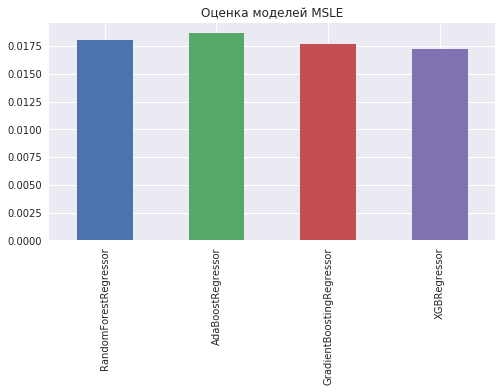

In [44]:
msle_scores.plot(kind='bar', title = 'Оценка моделей MSLE', figsize=(8,4))

In [45]:
best_params

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.726205959410574,
 'gamma': 0,
 'learning_rate': 0.16427501089864982,
 'max_delta_step': 0,
 'max_depth': 9,
 'min_child_weight': 8,
 'missing': None,
 'n_estimators': 50,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 0.5766855205204059}

In [46]:
best_estimator

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.726205959410574, gamma=0,
       learning_rate=0.16427501089864982, max_delta_step=0, max_depth=9,
       min_child_weight=8, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5766855205204059)

#### Подбираем max_depth и min_child_weight

In [47]:
xgb_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', XGBRegressor(**best_params))
])
xgb_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'reg__max_depth': randint(low=1, high=5),
    'reg__min_child_weight': randint(low=10, high=100),
}
fit_params = {'reg__eval_set': [(X_test, y_test)], 
              'reg__early_stopping_rounds': 10, 
              'reg__verbose': False,
              'reg__eval_metric': 'rmse'
             } 
best_estimator, best_params = find_params(xgb_pipe, xgb_params, 'neg_mean_squared_error', 50, fit_params)

XGBRegressor
Best params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.726205959410574, 'gamma': 0, 'learning_rate': 0.16427501089864982, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 23, 'missing': None, 'n_estimators': 50, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.5766855205204059}
MSLE на cv: 0.01897416401830713
MSLE на train: 0.012302197709851038
MSLE на test: 0.015183741904841508


#### Подбираем gamma

In [48]:
xgb_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', XGBRegressor(**best_params))
])
xgb_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'reg__gamma': uniform(loc=0.0, scale=0.5),
}
fit_params = {'reg__eval_set': [(X_test, y_test)], 
              'reg__early_stopping_rounds': 10, 
              'reg__verbose': False,
              'reg__eval_metric': 'rmse'
             } 
best_estimator, best_params = find_params(xgb_pipe, xgb_params, 'neg_mean_squared_error', 50, fit_params)


XGBRegressor
Best params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.726205959410574, 'gamma': 0.010292247147901223, 'learning_rate': 0.16427501089864982, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 23, 'missing': None, 'n_estimators': 50, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.5766855205204059}
MSLE на cv: 0.018867664208578702
MSLE на train: 0.012273356427302552
MSLE на test: 0.015506971021579687


#### Подбираем subsample и colsample_bytree

In [49]:
xgb_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', XGBRegressor(**best_params))
])
xgb_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'reg__subsample': uniform(loc=0.5, scale=0.5),
    'reg__colsample_bytree': uniform(loc=0.5, scale=0.5),
}
fit_params = {'reg__eval_set': [(X_test, y_test)], 
              'reg__early_stopping_rounds': 10, 
              'reg__verbose': False,
              'reg__eval_metric': 'rmse'
             } 
best_estimator, best_params = find_params(xgb_pipe, xgb_params, 'neg_mean_squared_error', 50, fit_params)


XGBRegressor
Best params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.728034992108518, 'gamma': 0.010292247147901223, 'learning_rate': 0.16427501089864982, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 23, 'missing': None, 'n_estimators': 50, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.8925879806965068}
MSLE на cv: 0.018256835957669307
MSLE на train: 0.010779319378928443
MSLE на test: 0.01624724811008273


#### Подбираем reg_alpha и reg_lambda

In [50]:
xgb_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', XGBRegressor(**best_params))
])
xgb_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'reg__reg_alpha': [0, 0.0001, 0.001, 0.1, 1],
    'reg__reg_lambda': [0, 0.0001, 0.001, 0.1, 1]
}
fit_params = {'reg__eval_set': [(X_test, y_test)], 
              'reg__early_stopping_rounds': 10, 
              'reg__verbose': False,
              'reg__eval_metric': 'rmse'
             } 
best_estimator, best_params = find_params(xgb_pipe, xgb_params, 'neg_mean_squared_error', 25, fit_params)


XGBRegressor
Best params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.728034992108518, 'gamma': 0.010292247147901223, 'learning_rate': 0.16427501089864982, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 23, 'missing': None, 'n_estimators': 50, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.8925879806965068}
MSLE на cv: 0.018256835957669307
MSLE на train: 0.010779319378928443
MSLE на test: 0.01624724811008273


#### уменьшаем learning_rate и увеличиваем n_estimators

In [51]:
xgb_pipe = Pipeline([
#    ('prep', Imputer()),
    ('reg', XGBRegressor(**best_params))
])
xgb_params = {    
#    'prep__strategy': ['mean', 'median', 'most_frequent'],
    'reg__learning_rate': [0.005],
    'reg__n_estimators': [1000]
}
fit_params = {'reg__eval_set': [(X_test, y_test)], 
              'reg__early_stopping_rounds': 10, 
              'reg__verbose': False,
              'reg__eval_metric': 'rmse'
             } 
best_estimator, best_params = find_params(xgb_pipe, xgb_params, 'neg_mean_squared_error', 1, fit_params)

XGBRegressor
Best params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.728034992108518, 'gamma': 0.010292247147901223, 'learning_rate': 0.005, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 23, 'missing': None, 'n_estimators': 1000, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.8925879806965068}
MSLE на cv: 0.026863993850180366
MSLE на train: 0.02065211752030175
MSLE на test: 0.025979245907526406


### Важность признаков

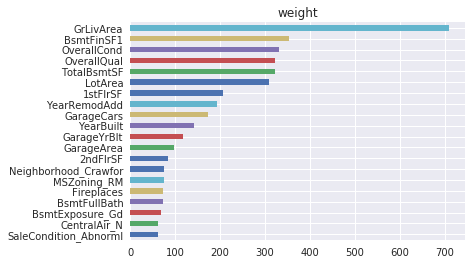

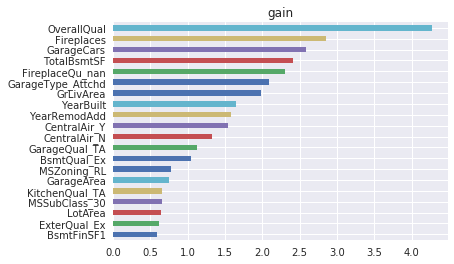

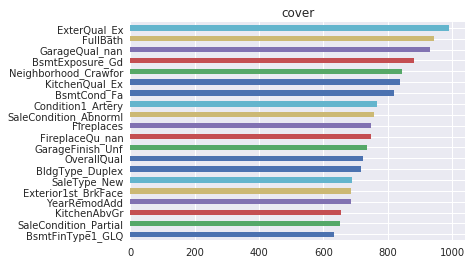

In [52]:
bst = best_estimator.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:20][::-1].plot(kind='barh', title=kind)

In [54]:
import xgbfir
xgbfir.saveXgbFI(best_estimator, OutputXlsxFile='xgbfi_report.xlsx')